In [1]:
run ='amery_v2km'

import numpy as np 
import os
import sys
import xarray as xr
import scipy.io as sio
import matplotlib.pyplot as plt
import datetime
from scipy.interpolate import griddata


proj_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(proj_dir,'data')
src_dir = os.path.join(proj_dir,'src')

sys.path.append(src_dir)


from ext.tools.NDinterp import NDinterp
from ext.tools.log_progress import log_progress

# set paths

T_mask_path = os.path.join(data_dir,'raw','tamura','EASE_landmask_H.data')
T_lat_lon_path = os.path.join(data_dir,'raw','tamura','EASE_latlon_H.data')
T_data_path = os.path.join(data_dir,'raw','tamura')
era_path = os.path.join(data_dir,'raw','era_interim','ERA_Interim_1992_2011.2daily.*winds.nc')
R_grid_path = os.path.join(data_dir,'proc',run+'_v11_grd.nc')

In [2]:
#load roms grid and convert lon to 0-360

R_grid = xr.open_dataset(R_grid_path)
R_lon = R_grid.lon_rho.values
R_lat = R_grid.lat_rho.values
R_angle = R_grid.angle.values
R_ulon = R_grid.lon_u.values
R_vlon = R_grid.lon_v.values
R_ulat = R_grid.lat_u.values
R_vlat = R_grid.lat_v.values


R_lon[R_lon<0]+=360
R_ulon[R_ulon<0]+=360
R_vlon[R_vlon<0]+=360

R_grid.load()


<xarray.Dataset>
Dimensions:    (eta_rho: 750, xi_rho: 900, eta_psi: 749, xi_psi: 899,
                eta_u: 750, xi_u: 899, eta_v: 749, xi_v: 900)
Dimensions without coordinates: eta_rho, xi_rho, eta_psi, xi_psi, eta_u, xi_u,
                                eta_v, xi_v
Data variables: (12/31)
    spherical  <U3 '"T"'
    xl         float64 1.776e+06
    el         float64 1.507e+06
    angle      (eta_rho, xi_rho) float64 1.568 1.568 1.568 ... 0.8691 0.8693
    pm         (eta_rho, xi_rho) float64 0.0004954 0.0004954 ... 0.0005286
    pn         (eta_rho, xi_rho) float64 0.0004956 0.0004956 ... 0.0005293
    ...         ...
    x_v        (eta_v, xi_v) float64 1.501e+06 1.503e+06 ... 3.297e+06 3.299e+06
    y_v        (eta_v, xi_v) float64 2e+03 2e+03 2e+03 ... 1.498e+06 1.498e+06
    mask_rho   (eta_rho, xi_rho) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    mask_psi   (eta_psi, xi_psi) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    mask_u     (eta_u, xi_u) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
    mask_v     (eta_v, xi_v) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    history:  GRID file using make_grid.py,2024-02-11
    type:     ROMS grid file

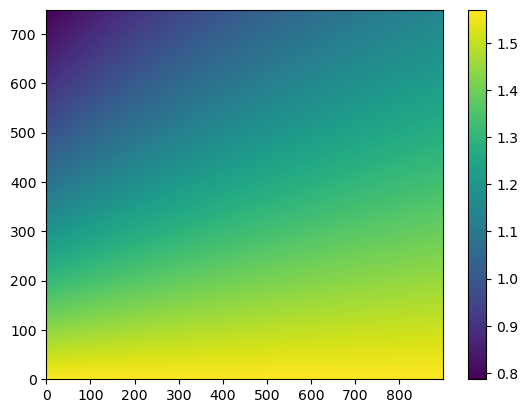

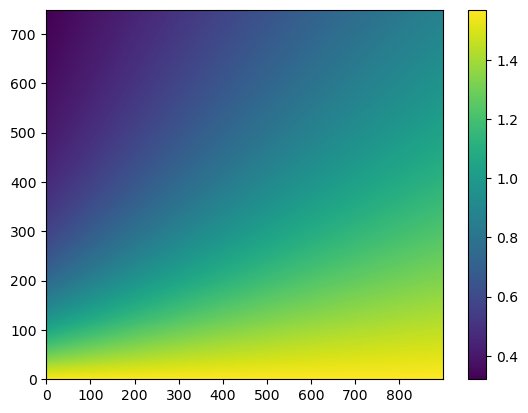

In [4]:
import pyproj
geod = pyproj.Geod(ellps='WGS84')
az_forward, az_back, dx = geod.inv(R_lon[:,:-1], R_lat[:,:-1], \
                                    R_lon[:,1:], R_lat[:,1:])

angle = 0.5 * (az_forward[1:,:] + az_forward[:-1,:])
angle_rho = (90 - angle) * np.pi/180
plt.pcolormesh(angle_rho)
plt.colorbar()
angle_rho2 = np.arctan2(np.diff(0.5*(R_lat[1:,:]+R_lat[:-1,:])), \
                                    np.diff(0.5*(R_lon[1:,:]+R_lon[:-1,:])))  
# aLon = 0.5*(R_lon[0:,1:]+R_lon[:-1,:-1])
# aLat = 0.5*(R_lat[0:,1:]+R_lat[:-1,:-1])
plt.show()
plt.pcolormesh(angle_rho2)
plt.colorbar()



In [5]:
### method from Brian Powell group

def _distq(lon1, lat1, lon2, lat2):
    """
    Compute the geodesic distance between lat/lon points. This code is
    taken from the dist.f routine and the Matlab version distg.m passed
    around WHOI and APL. This was stripped down to use the WGS84 ellipsoid.

    Parameters
    ----------
    lon1 : array_like or scalar
        Input array of source longitude(s)
    lat1 : array_like or scalar
        Input array of source latitude(s)
    lon2 : array_like or scalar
        Input array of destination longitude(s)
    lat2 : array_like or scalar
        Input array of destination latitude(s)

    Returns
    -------
    distance : array or scalar of distance in meters
    angle: array or scalar of angle in radians

    """
    lon1 = np.asanyarray(np.radians(lon1))
    lat1 = np.asanyarray(np.radians(lat1))
    lon2 = np.asanyarray(np.radians(lon2))
    lat2 = np.asanyarray(np.radians(lat2))

    # # If one of the points is a singleton and the other is an
    # array, make them the same size
    if lon1.size == 1 and lon2.size > 1:
        lon1 = lon1.repeat(lon2.size)
        lat1 = lat1.repeat(lat2.size)
    if lon2.size == 1 and lon1.size > 1:
        lon2 = lon2.repeat(lon1.size)
        lat2 = lat2.repeat(lat1.size)

    # Set the WGS84 parameters
    A = 6378137.
    E = 0.081819191
    B = np.sqrt(A * A - (A * E)**2)
    EPS = E * E / (1.0 - E * E)

    # Move any latitudes off of the equator
    lat1[lat1 == 0] = np.finfo(float).eps
    lat2[lat2 == 0] = -np.finfo(float).eps

    # COMPUTE THE RADIUS OF CURVATURE IN THE PRIME VERTICAL FOR EACH POINT
    xnu1 = A / np.sqrt(1.0 - (E * np.sin(lat1))**2)
    xnu2 = A / np.sqrt(1.0 - (E * np.sin(lat2))**2)

    TPSI2 = (1.0 - E * E) * np.tan(lat2) + E * E * xnu1 * np.sin(lat1) / \
        (xnu2 * np.cos(lat2))
    PSI2 = np.arctan(TPSI2)

    DPHI2 = lat2 - PSI2
    DLAM = (lon2 - lon1) + np.finfo(float).eps
    CTA12 = np.sin(DLAM) / (np.cos(lat1) * TPSI2 - np.sin(lat1) * np.cos(DLAM))
    A12 = np.arctan(CTA12)
    CTA21P = np.sin(DLAM) / (np.sin(PSI2) * np.cos(DLAM) -
                             np.cos(PSI2) * np.tan(lat1))
    A21P = np.arctan(CTA21P)

    # C    GET THE QUADRANT RIGHT
    DLAM2 = (np.abs(DLAM) < np.pi).astype(int) * DLAM + \
        (DLAM >= np.pi).astype(int) * (-2 * np.pi + DLAM) + \
        (DLAM <= -np.pi).astype(int) * (2 * np.pi + DLAM)
    A12 = A12 + (A12 < -np.pi).astype(int) * 2 * np.pi - \
        (A12 >= np.pi).astype(int) * 2 * np.pi
    A12 = A12 + np.pi * np.sign(-A12) * \
        (np.sign(A12).astype(int) != np.sign(DLAM2))
    A21P = A21P + (A21P < -np.pi).astype(int) * 2 * np.pi - \
        (A21P >= np.pi).astype(int) * 2 * np.pi
    A21P = A21P + np.pi * np.sign(-A21P) * \
        (np.sign(A21P).astype(int) != np.sign(-DLAM2))

    SSIG = np.sin(DLAM) * np.cos(PSI2) / np.sin(A12)

    dd1 = np.array([np.cos(lon1) * np.cos(lat1),
                    np.sin(lon1) * np.cos(lat1), np.sin(lat1)])
    dd2 = np.array([np.cos(lon2) * np.cos(lat2),
                    np.sin(lon2) * np.cos(lat2), np.sin(lat2)])
    dd2 = np.sum((dd2 - dd1)**2, axis=0)
    bigbrnch = (dd2 > 2).astype(int)

    SIG = np.arcsin(SSIG) * (bigbrnch == 0).astype(int) + \
        (np.pi - np.arcsin(SSIG)) * bigbrnch

    SSIGC = -np.sin(DLAM) * np.cos(lat1) / np.sin(A21P)
    SIGC = np.arcsin(SSIGC)
    A21 = A21P - DPHI2 * np.sin(A21P) * np.tan(SIG / 2.0)

    # C   COMPUTE RANGE
    G2 = EPS * (np.sin(lat1))**2
    G = np.sqrt(G2)
    H2 = EPS * (np.cos(lat1) * np.cos(A12))**2
    H = np.sqrt(H2)
    SIG2 = SIG * SIG
    TERM1 = -H2 * (1.0 - H2) / 6.0
    TERM2 = G * H * (1.0 - 2.0 * H2) / 8.0
    TERM3 = (H2 * (4.0 - 7.0 * H2) - 3.0 * G2 * (1.0 - 7.0 * H2)) / 120.0
    TERM4 = -G * H / 48.0
    rng = xnu1 * SIG * (1.0 + SIG2 * (TERM1 + SIG * TERM2 + SIG2 * TERM3 +
                                      SIG2 * SIG * TERM4))

    return rng, A12


def earth_angle(lon1, lat1, lon2, lat2):
    """
    Compute the angle between lat/lon points. NOTE: The bearing angle
    is computed, but then converted to geometric (counter-clockwise)
    angle to be returned.

    Parameters
    ----------
    lon1 : array_like or scalar
        Input array of source longitude(s)
    lat1 : array_like or scalar
        Input array of source latitude(s)
    lon2 : array_like or scalar
        Input array of destination longitude(s)
    lat2 : array_like or scalar
        Input array of destination latitude(s)

    Returns
    -------
    angle : array or scalar of bearing in radians

    """
    _, angle = _distq(lon1, lat1, lon2, lat2)
    return (np.pi / 2.0 - angle)


# Calculate the angle between the points
angle = np.zeros(R_lat.shape)
angle[:, :-1] = earth_angle(R_lon[:, :-1],
                                    R_lat[:, :-1], R_lon[:, 1:], R_lat[:, 1:])
angle[:, -1] = angle[:, -2]

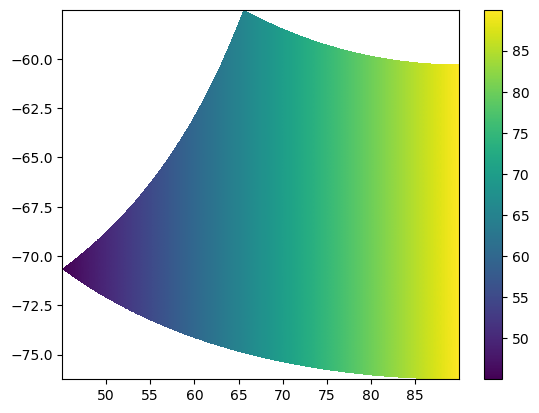

In [6]:
plt.pcolormesh(R_lon,R_lat,np.rad2deg(angle))
plt.axis((R_lon.min(),R_lon.max(),R_lat.min(),R_lat.max()))
plt.colorbar()

In [7]:
bedmachine_v3_path = os.path.join(data_dir,'raw','BedMachineAntarctica-v3','BedMachineAntarctica-v3.nc')

bm3_raw = xr.load_dataset(bedmachine_v3_path)
bm3_raw

<xarray.Dataset>
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y          (y) int32 3333000 3332500 3332000 ... -3332000 -3332500 -3333000
Data variables:
    mapping    |S1 b''
    mask       (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    firn       (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    surface    (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    thickness  (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    bed        (y, x) float32 -5.916e+03 -5.92e+03 ... -3.664e+03 -3.664e+03
    errbed     (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    source     (y, x) int8 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    dataid     (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    geoid      (y, x) int16 -1 -1 -1 -1 -1 -1 -1 ... -19 -19 -19 -19 -19 -19 -19
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

In [8]:


## convert convert polarstereo to lat/lon and vice versa.
from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")


X,Y = np.meshgrid(bm3_raw.x[0:-1:50],bm3_raw.y[0:-1:50])

bm3_lat,bm3_lon = ps_to_ll.transform(X,Y)


angle_ole = bm3_lon/180.0*np.pi


_,dxdxi = np.gradient(bm3_lon)
_,dydxi = np.gradient(bm3_lat)

angle_charles = np.arctan2(dydxi,dxdxi)
angle_charles

angle_brian = np.zeros(bm3_lon.shape)
angle_brian[:, :-1] = earth_angle(bm3_lon[:, :-1],
                                    bm3_lat[:, :-1], bm3_lon[:, 1:], bm3_lat[:, 1:])
angle_brian[:, -1] = angle_brian[:, -2]

# angle_brian = angle_brian[angle_brian>180]-360
angle_brian[np.rad2deg(angle_brian)>180] = angle_brian[np.rad2deg(angle_brian)>180] - np.deg2rad(360)

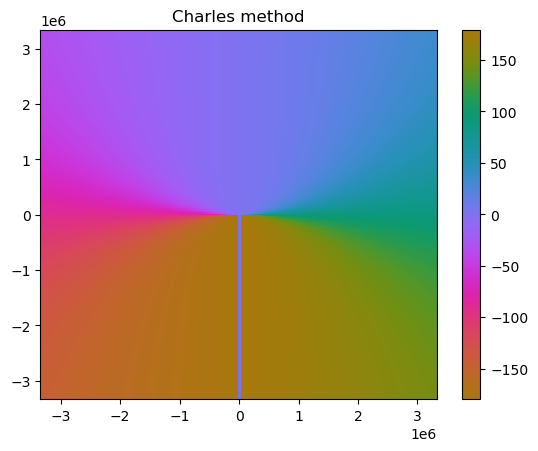

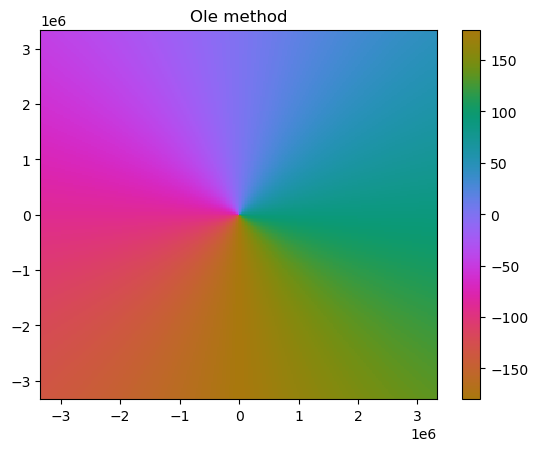

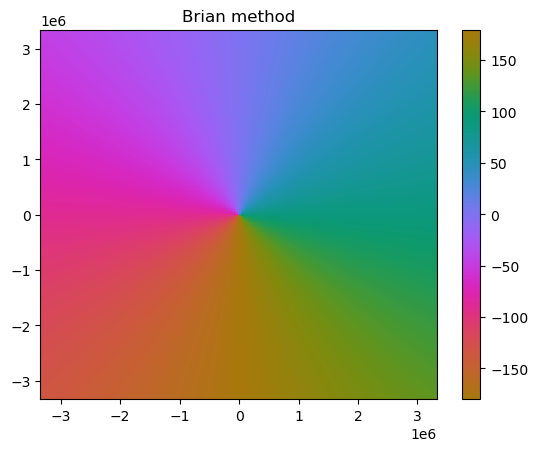

In [9]:
import cmocean

plt.pcolormesh(X,Y,np.rad2deg(angle_charles),cmap='cmo.phase')
plt.colorbar()
plt.title('Charles method')
plt.show()
plt.pcolormesh(X,Y,np.rad2deg(angle_ole),cmap='cmo.phase')
plt.colorbar()
plt.title('Ole method')
plt.show()
plt.pcolormesh(X,Y,np.rad2deg(angle_brian),cmap='cmo.phase')
plt.colorbar()
plt.title('Brian method')
plt.show()

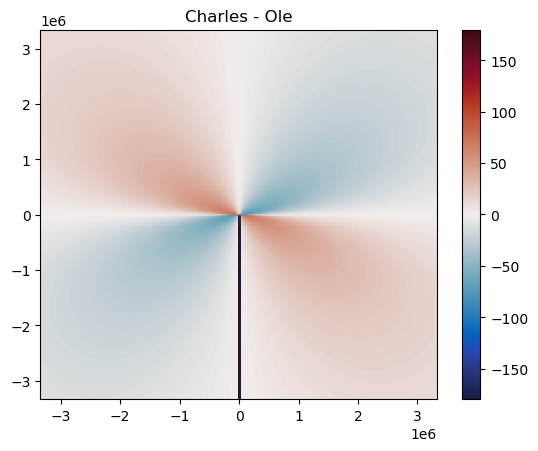

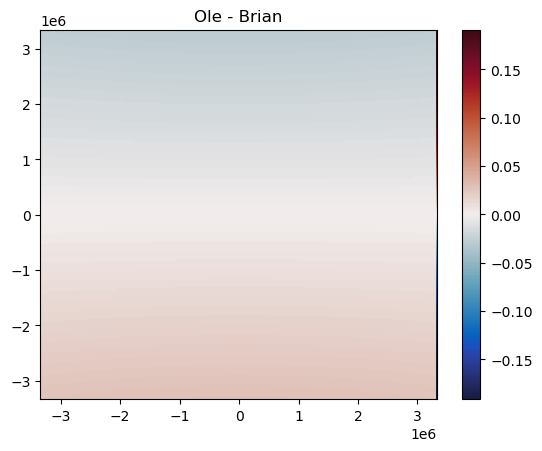

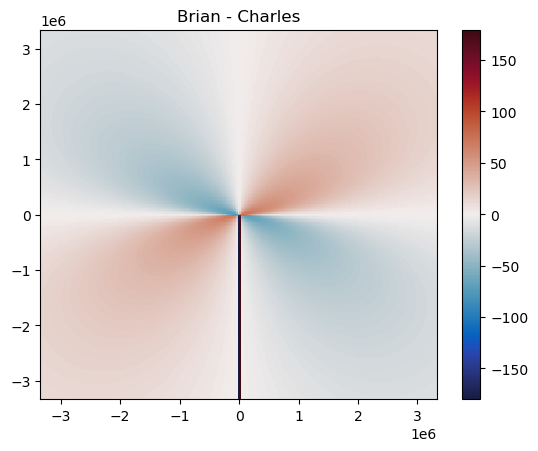

In [10]:

plt.pcolormesh(X,Y,np.rad2deg(angle_charles) - np.rad2deg(angle_ole),cmap='cmo.balance')
plt.colorbar()
plt.title('Charles - Ole')
plt.show()
plt.pcolormesh(X,Y,np.rad2deg(angle_ole)-np.rad2deg(angle_brian),cmap='cmo.balance')
plt.colorbar()
plt.title('Ole - Brian')
plt.show()
plt.pcolormesh(X,Y,np.rad2deg(angle_brian) - np.rad2deg(angle_charles),cmap='cmo.balance')
plt.colorbar()
plt.title('Brian - Charles')
plt.show()